# Image Processing

In this notebook, we are testing various ways to load and analyze the Tiff images.

## Image Visualization

I didn't find any good softwares to directly view those scientific Tiff images on my laptop. I will use `tifffile` package to display them in this notebook.

Below is the simple example of loading one of those tiff images into `numpy` array and display it using `matplotlib`.

In [127]:
from skimage.external.tifffile import imread
import matplotlib.pyplot as plt
import numpy as np
import cv2

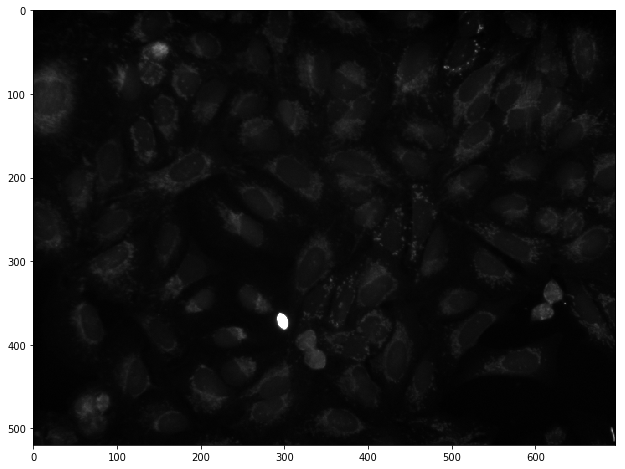

In [114]:
image = imread("data/test/test.tif", key=0)
plt.figure(figsize=(16,8))
plt.imshow(image, cmap='gray')
plt.show()

In [116]:
dim = image.shape
print(dim)

(520, 696)


## Depth of field (DOF)

For each well in the plate, there are $9$ images taken in $9$ different DOF.

In [181]:
# Load the 9 images
imgs = []
for i in range(1, 10):
    imgs.append(imread("data/test/dof/dof{}.tif".format(i), key=0))

# Stack 9 images together
combi = np.vstack(
    (
        np.hstack((imgs[0], imgs[1], imgs[2])),
        np.hstack((imgs[3], imgs[4], imgs[5])),
        np.hstack((imgs[6], imgs[7], imgs[8]))
    )
)

# Draw white borders
thickness = 2
cv2.line(combi, (0, dim[0]), (dim[1]*3-1, dim[0]), 4096, thickness)
cv2.line(combi, (0, dim[0]*2-1), (dim[1]*3-1, dim[0]*2-1), 4096, thickness)
cv2.line(combi, (dim[1], 0), (dim[1], dim[0]*3-1), 4096, thickness)
cv2.line(combi, (dim[1]*2-1, 0), (dim[1]*2-1, dim[0]*3-1), 4096, thickness);

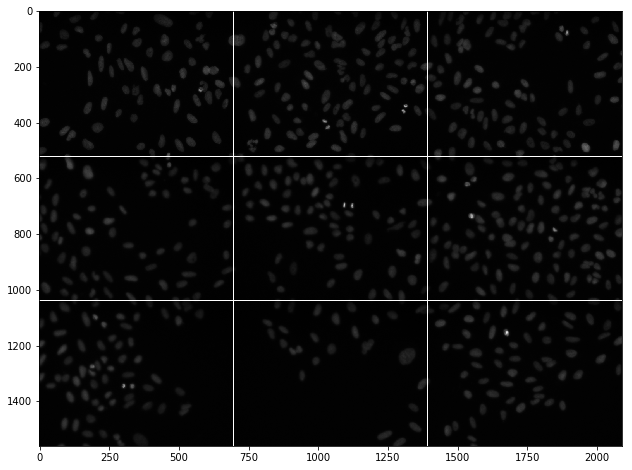

In [182]:
plt.figure(figsize=(16,8))
plt.imshow(combi, cmap='gray')
plt.show()

## Channels

Each well image has five channels. We can try to merge some of those channels to visualize the images.

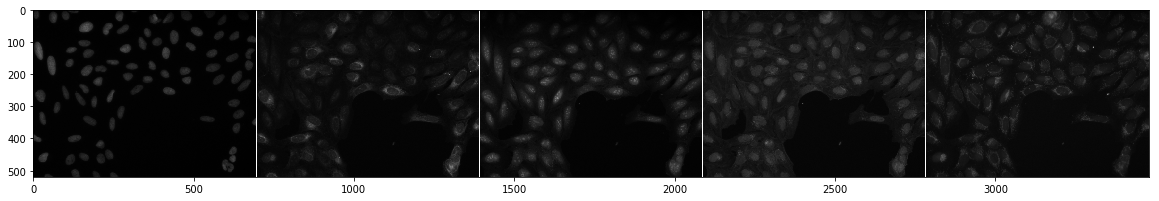

In [183]:
# Load 5 images
imgs = []
for i in range(1, 6):
    imgs.append(imread("data/test/channel/c{}.tif".format(i), key=0))

height = imgs[0].shape[0]
width = imgs[0].shape[1]

# Display 5 images side by side
combi = np.hstack(imgs)

# Add white borders
for i in range(1,5):
    cv2.line(combi, (i*width, 0), (i*width, height), 4096, thickness)

plt.figure(figsize=(20,20))
plt.imshow(combi, cmap="gray")
plt.show()

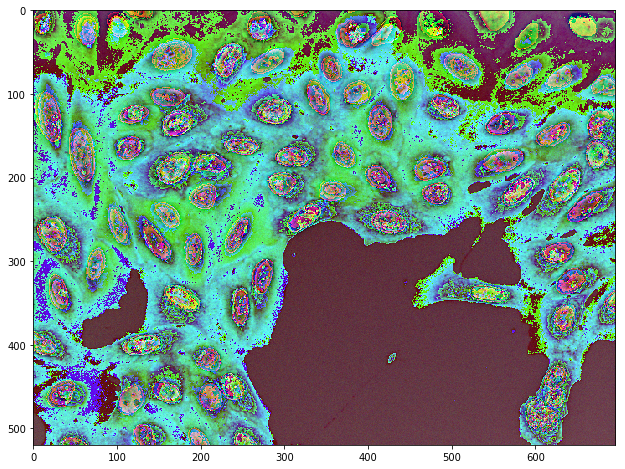

In [166]:
# Display the first three channels
merged_123 = cv2.merge((imgs[0], imgs[1], imgs[2])).astype(float)

plt.figure(figsize=(16,8))
plt.imshow(merged_123)
plt.show()

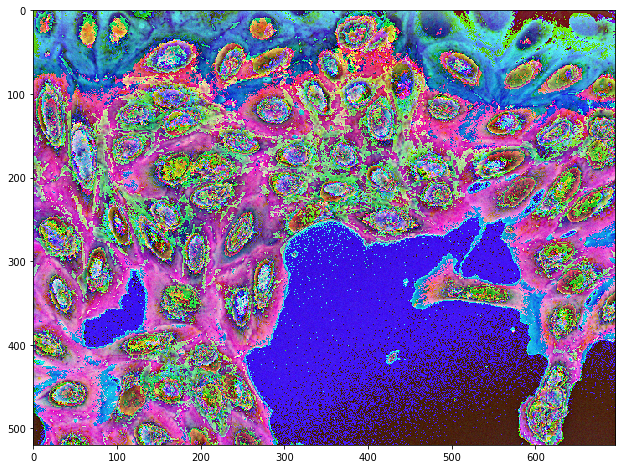

In [171]:
# Display the last three channels
merged_345 = cv2.merge((imgs[2], imgs[3], imgs[4])).astype(float)

plt.figure(figsize=(16,8))
plt.imshow(merged_345)
plt.show()